## Parâmetros de treinamento

* **Pontos de colocação por época (amostragem uniforme):**

  * **Domínio (PDE):** **1.000** (`num_domain=1000`)
  * **Contorno (todas as bordas somadas):** **1.000** (`num_boundary=1000`)
    — distribuídos automaticamente pelo DeepXDE entre:
    $u_x=0$ em $y=0,1$; $u_y=0$ em $x=0,1$ e $y=0$; $\sigma_{xx}=0$ em $x=0,1$; $\sigma_{yy}$ prescrito em $y=1$.
  * **Avaliação (plots):** **10.000** pontos (grade 100×100).
* **Função de ativação:** `tanh`
* **Otimizadores:**
  **Adam** (`lr = 1e-3`, **5.000** iterações) → **L-BFGS** (refino) → **Adam** (`lr = 1e-4`, **2.000** iterações)
  *Com reamostragem de pontos do PDE a cada 1000 iterações (`PDEPointResampler`).*
* **Material (plano de deformações):** $\lambda=1.0$, $\mu=0.5$; **amplitude** $Q=4.0$.
* **Forças de corpo (conforme enunciado):**

  $$
  \begin{aligned}
  f_x &= -2Q\lambda\,y(1-2x)e^{y^2} + \mu\big[-2Qy(1-2x)e^{y^2} + \pi^2\sin(\pi y)\big],\\
  f_y &= \lambda\big[-4Qy^2(-x^2+x)e^{y^2}-2Q(-x^2+x)e^{y^2}\big] \\
      &\quad+ \mu\big[-8Qy^2(-x^2+x)e^{y^2}-4Q(-x^2+x)e^{y^2}+2Qe^{y^2}\big].
  \end{aligned}
  $$

## Estrutura da rede

* **Arquitetura (PFNN – rede mista):** **2–20–20–20–5**

  * **Entrada:** 2 nós $(x,y)$
  * **Ocultas:** 3 camadas com **20 neurônios** (`tanh`)
  * **Saída:** 5 nós $(u_x,u_y,\sigma_{xx},\sigma_{yy},\sigma_{xy})$
* **Inicialização:** Glorot (Xavier) uniforme

## Condições de contorno

* **Deslocamentos (soft):**

  * $u_x=0$ em $y=0$ e $y=1$
  * $u_y=0$ em $x=0,1$ e $y=0$
* **Tensões (soft):**

  * $\sigma_{xx}=0$ em $x=0$ e $x=1$
  * **Tração no topo:** $\sigma_{yy}(x,1)=2e(\lambda+2\mu)Q(x-x^2)$
  *Motivação:* hard BC reduz a competição na loss e acelera a convergência de fronteira; **soft** é mais simples de configurar e mais flexível para ajustes de pesos.


## Função de perda e pesos

* **Termos de PDE (5):**
  $\nabla\!\cdot\sigma + f=0$ (duas equações de momento) **+** compatibilidade $\sigma(u)\approx\sigma$ (três equações: $\sigma_{xx},\sigma_{yy},\sigma_{xy}$).
* **Pesos usados:**
  `pde_w = [1, 1, 2, 2, 2]` (momento x, momento y, $\sigma_{xx},\sigma_{yy},\sigma_{xy}$)
  `bc_w  = [1,1,1,1,1,1,1,50]` (todas as Dirichlet + **tração no topo com peso 50**)
* **O porque desses pesos?**

  * **Peso maior** aos termos de **compatibilidade** para que as tensões de saída não “fujam” das leis constitutivas, estabilizando o treinamento na formulação mista.
  * A **tração no topo** recebe **50** para garantir que $\sigma_{yy}(x,1)$ respeite o **perfil parabólico** — é a BC mais sensível; sem esse reforço a rede tende a “amortecer” o pico central.

## Solução de referência e validação

* **Solução analítica usada para validação:**

  $$
  u_x=\sin(\pi y),\qquad
  u_y=Q(x-x^2)\big(e^{y^2}-1\big)
  $$

  *(o termo “$-1$” é para cumprir $u_y=0$ na base; não altera $\partial u_y/\partial y$ e, portanto, **mantém** tensões e tração do topo do enunciado).*
* **Pós-processamento:** comparação em grade 100×100 das cinco variáveis $(u_x,u_y,\sigma_{xx},\sigma_{yy},\sigma_{xy})$, com mapas da solução exata, solução PINN e **erro absoluto**, além de métricas $L_2$ relativo e $L_\infty$ absoluto.

## Comentário sobre **soft vs hard** no DeepXDE

* **Soft BC**
  *Prós:* simples, permite ponderar conflitos via **pesos**; útil quando há cargas/trações complexas.
  *Contras:* exige tuning de pesos; pode “vazar” na fronteira.
* **Hard BC (output transform)**
  *Prós:* BCs de deslocamento satisfeitas **exatamente**, menos termos na loss, convergência mais rápida nas bordas.
  *Contras:* exige derivar um transform adequado; pode **reduzir a expressividade** se for muito restritivo para as tensões.

**Motivações da escolha:** usar **soft** para todas as BCs é suficiente e flexível; manter o **transform hard** como opção (ou mesmo híbrido: hard para $u$, soft para $\sigma$) oferece o melhor dos dois com um overhead mínimo.

## Observações:

Após diversas tentativas de encontrar uma PINN capaz de reproduzir o fenômeno com maior precisão, optou-se por entregar o resultado obtido neste estágio de convergência. Foram testadas inúmeras variações do código, desde versões simples até modelos com ajustes incorretos (incluindo erros na formulação da solução exata). A cada versão, analisou-se o impacto individual de parâmetros como: num_domain, num_boundary, taxa de aprendizado do Adam, número de épocas, funções de ativação, tamanho das camadas ocultas e sequência de refinamento (Adam → L-BFGS e Adam → L-BFGS → Adam). O num_domain e o num_boundary variaram de 100 a 10.000 pontos (incrementos de 500), mas acima de 1000–2000 não houve melhora significativa na resposta, apenas aumento no tempo de treinamento. A taxa de aprendizado inicial foi testada entre 1e-2 e 1e-5, sendo mais efetivo usar 1e-3 no pré-treinamento e 1e-4 no refinamento final. O número de épocas variou de 500 a 50.000, sem ganhos relevantes após ~1.000 iterações, e com tendência a ruídos para épocas muito altas (principalmente modelos com overfitting). Entre as funções de ativação testadas (tanh, gelu, swish, sin), o tanh apresentou melhor estabilidade e convergência.  

Para as camadas ocultas, foram avaliadas configurações de 3 a 6 camadas e 20 a 60 neurônios, sendo que modelos acima de 3×30 neurônios não trouxeram melhorias perceptíveis. Assim, a configuração final adotada foi [20]×3, tanh, num_domain=1000, num_boundary=1000, sequência Adam (1e-3) → L-BFGS → Adam (1e-4), e pesos na loss ajustados para reforçar especialmente a tração no topo, garantindo um equilíbrio entre custo computacional e qualidade da solução.


Compiling model...
'compile' took 0.000409 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric   
0         [1.20e+02, 5.05e+01, 4.37e-01, 4.06e+00, 4.84e-01, 4.39e-01, 4.23e-02, 2.46e-01, 7.30e-02, 7.97e-02, 2.55e-01, 1.72e-01, 3.13e+03]    [5.71e+01, 2.40e+01, 2.98e-01, 4.35e+00, 4.06e-01, 4.39e-01, 4.23e-02, 2.46e-01, 7.30e-02, 7.97e-02, 2.55e-01, 1.72e-01, 3.13e+03]    [9.89e-01]    
300       [2.23e+00, 1.54e+00, 3.49e-01, 6.14e-01, 9.42e-01, 6.56e-03, 1.10e-02, 3.08e-01, 1.44e-02, 6.61e-02, 4.92e-01, 2.27e-01, 1.87e+00]    [3.01e+00, 1.49e+00, 3.29e-01, 7.29e-01, 6.41e-01, 6.56e-03, 1.10e-02, 3.08e-01, 1.44e-02, 6.61e-02, 4.92e-01, 2.27e-01, 1.87e+00]    [5.70e-01]    
600       [6.37e-01, 3.68e-01, 1.62e-01, 1.96e-01, 4.36e

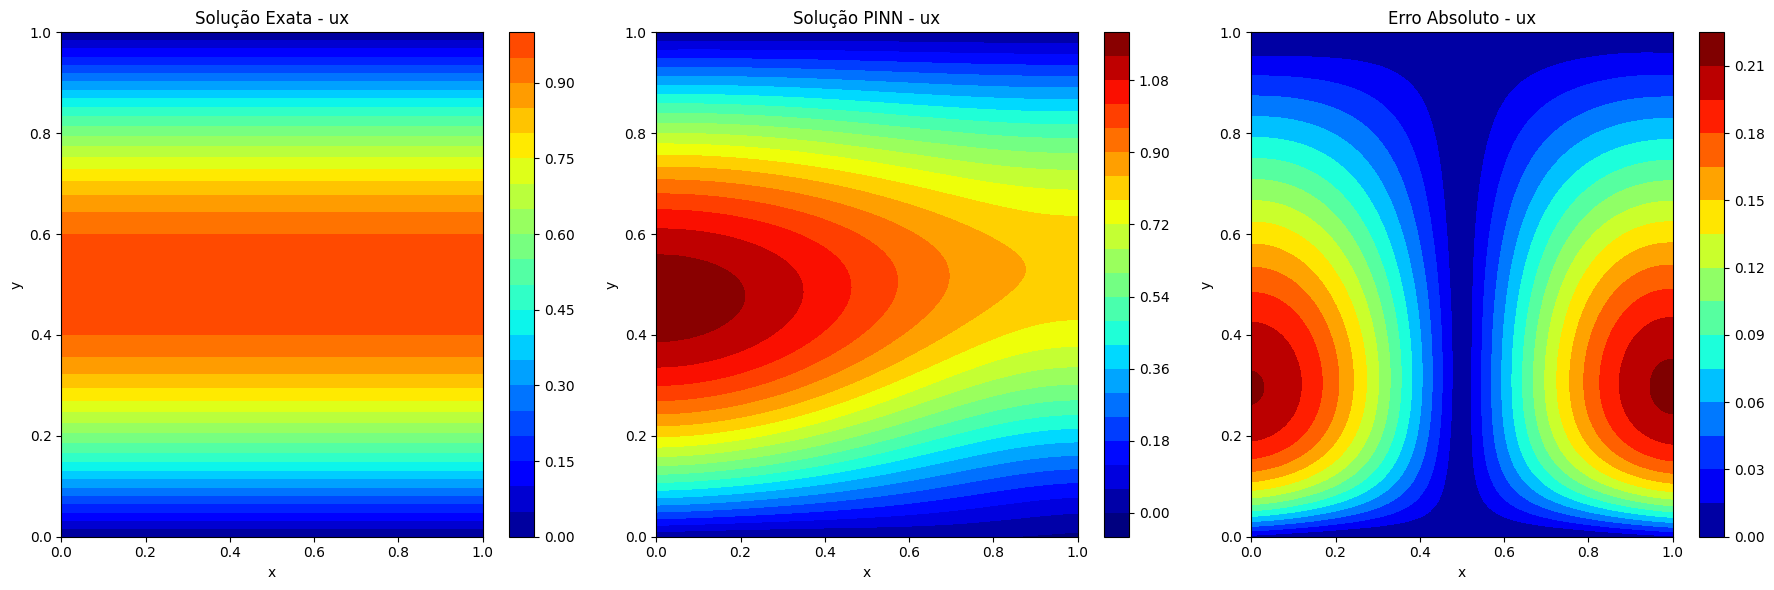

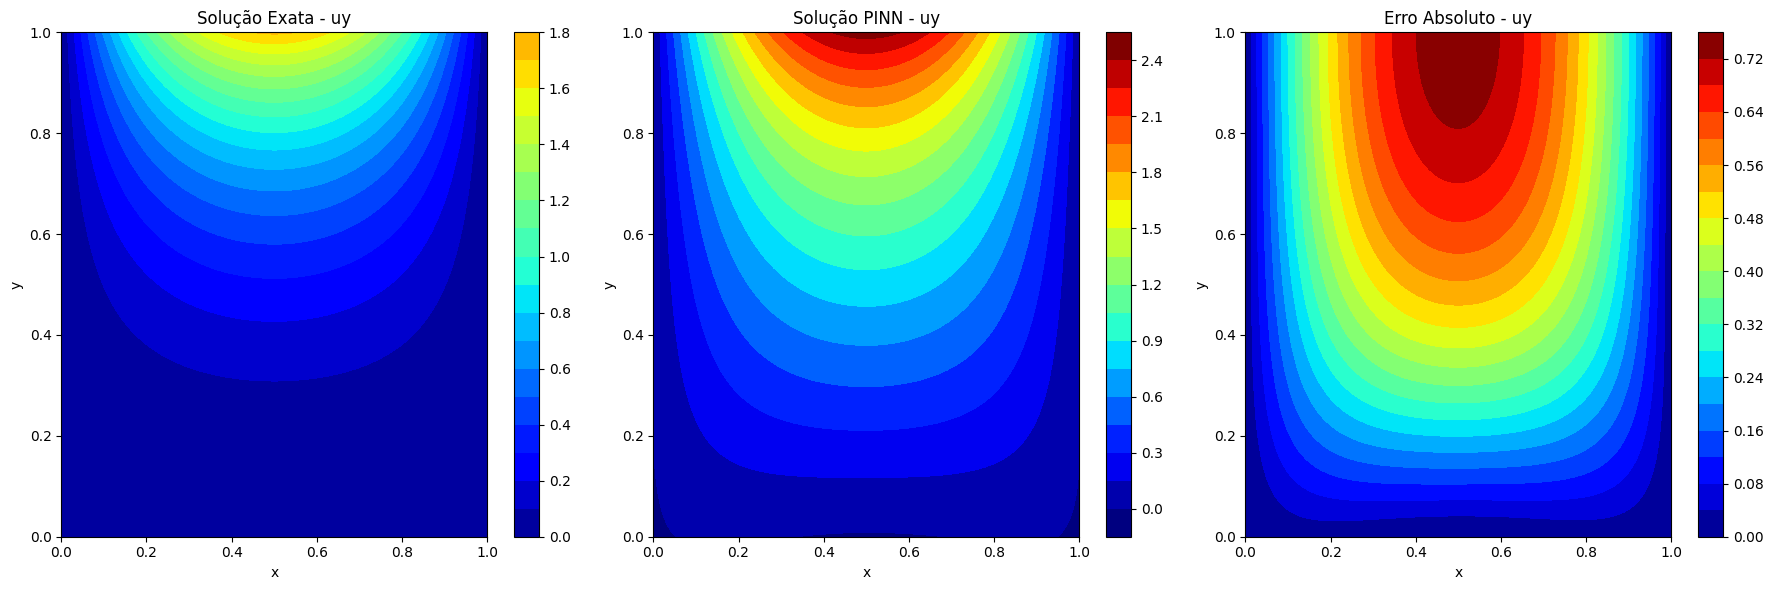

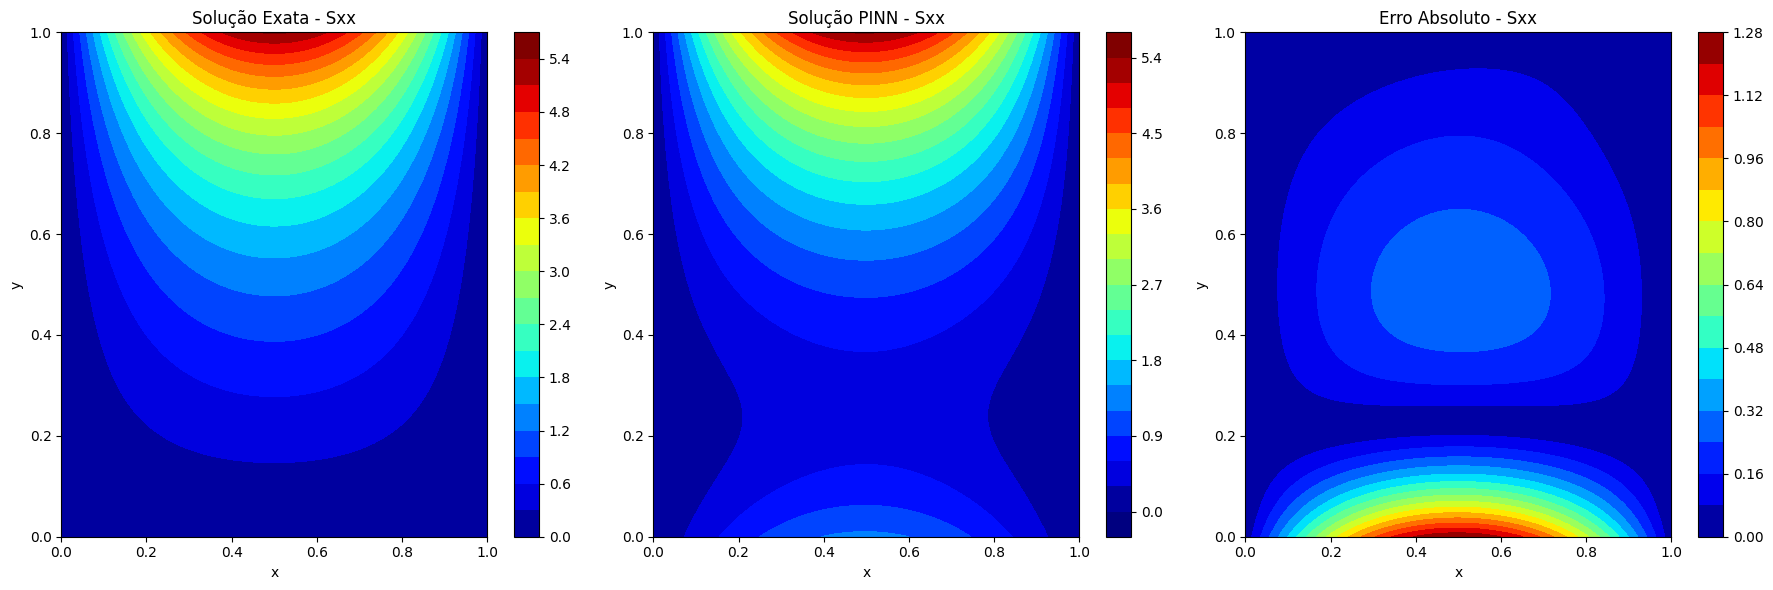

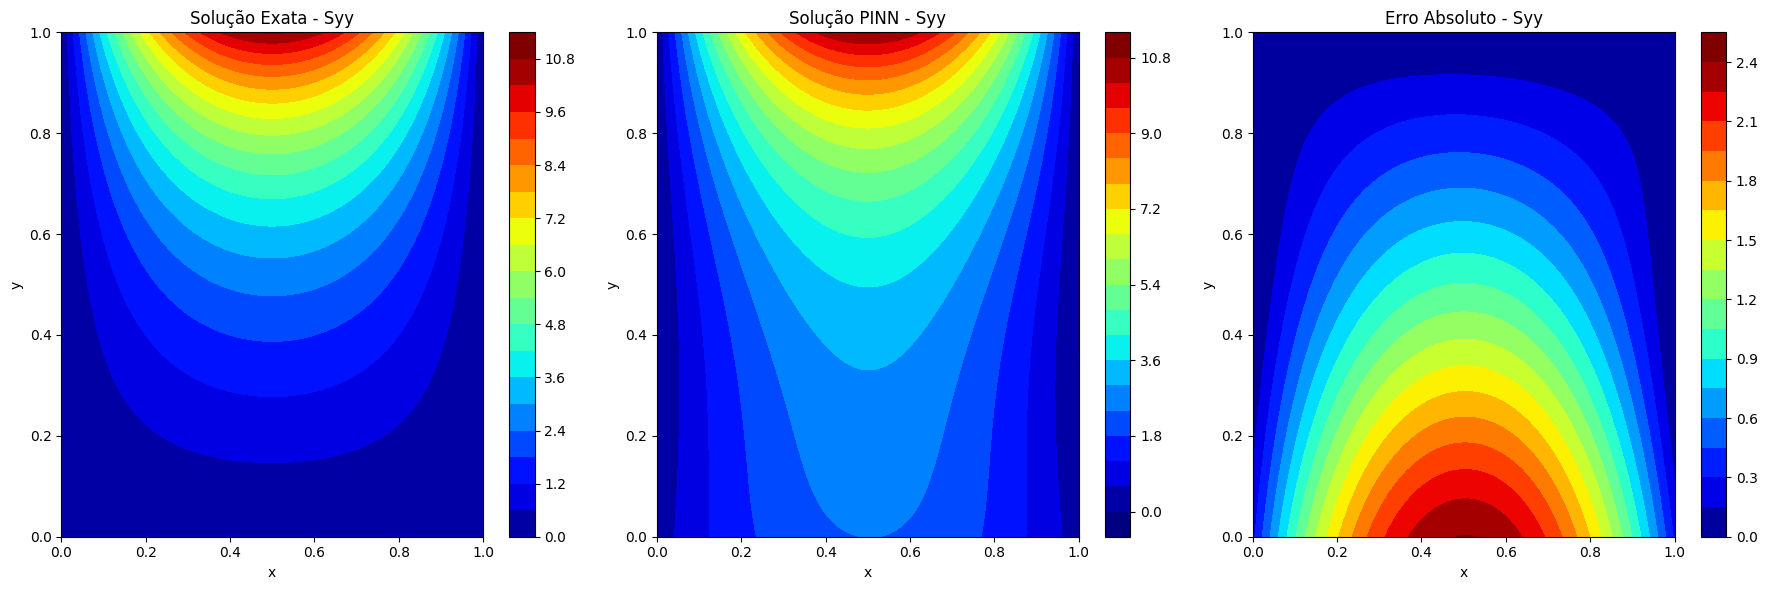

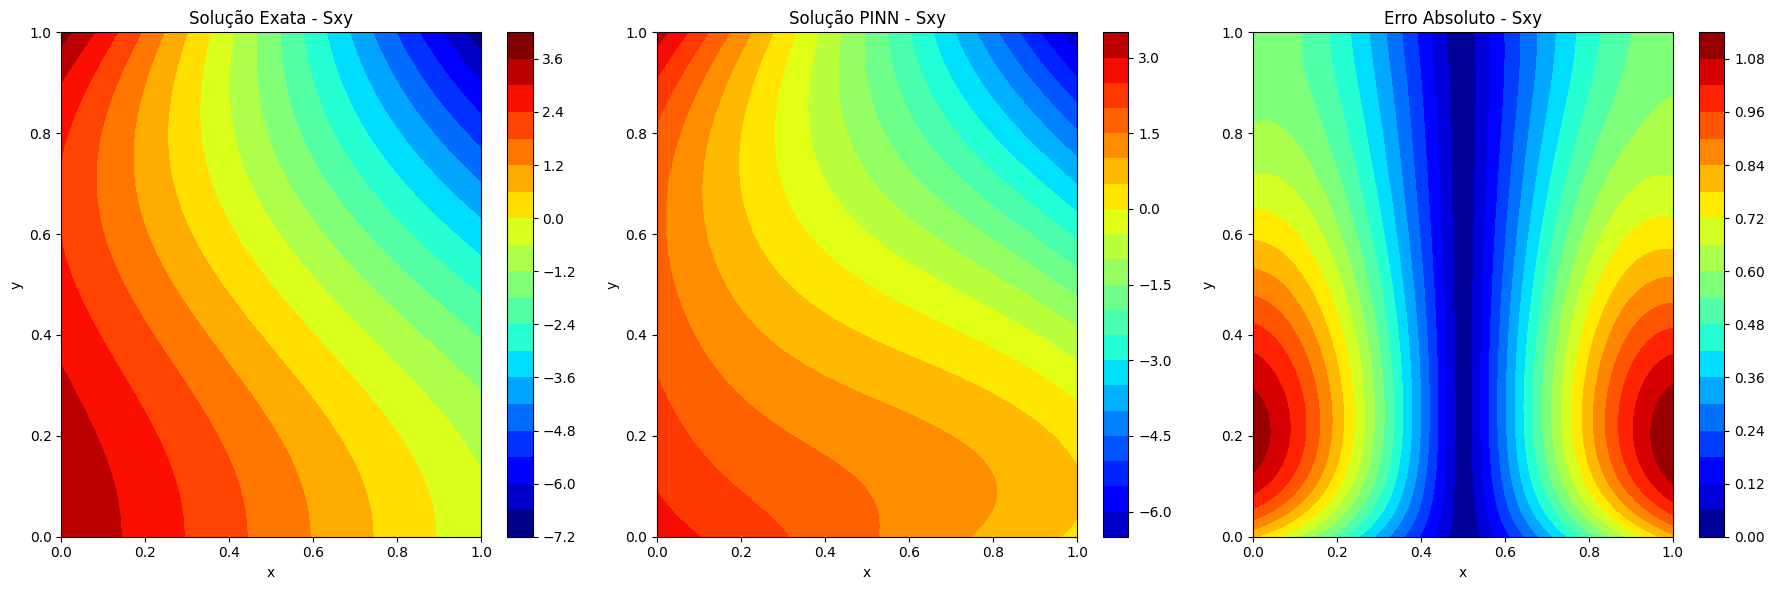

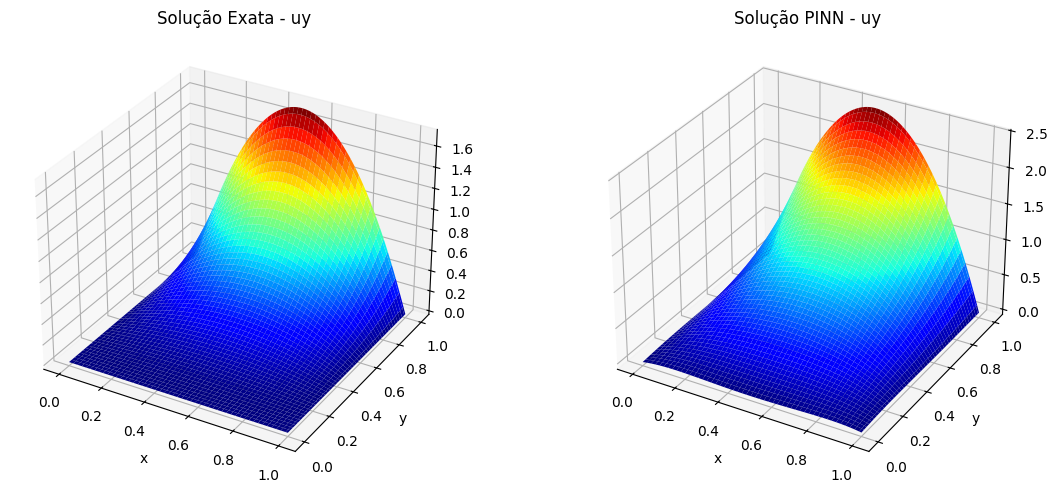

===== ERROS POR VARIÁVEL (grid 100x100) =====
  ux: L2_rel=1.4546e-01 | L_inf_abs=2.1347e-01
  uy: L2_rel=8.2081e-01 | L_inf_abs=7.4682e-01
 Sxx: L2_rel=1.5481e-01 | L_inf_abs=1.2666e+00
 Syy: L2_rel=2.9650e-01 | L_inf_abs=2.4043e+00
 Sxy: L2_rel=2.7735e-01 | L_inf_abs=1.1357e+00


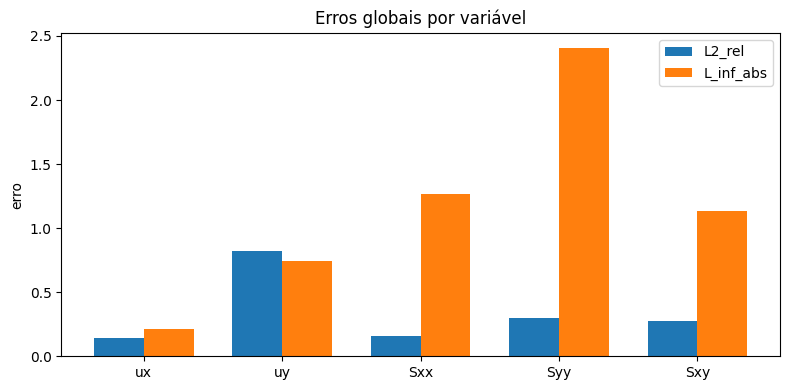

[info] plot_loss_history falhou: 'list' object has no attribute 'loss_train'


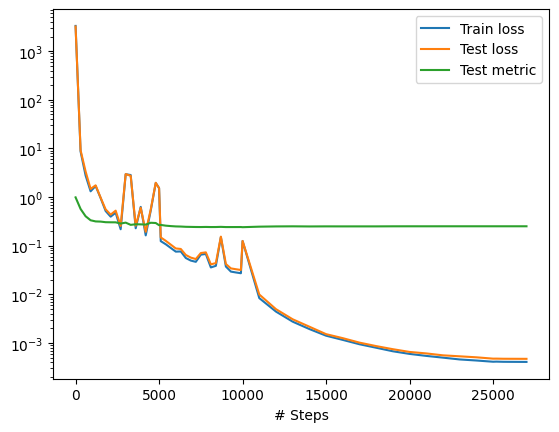

In [ ]:
# DeepXDE + PyTorch: PINN para elasticidade em plano de deformações
# (quadrado unitário) com solução analítica "clamped" (engastada na base).
# Sem usar deepxde.backend nas expressões do PDE; tudo em torch/math.

import math
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
import torch

# ---------------------------------------------------------------------
# Parâmetros do material e amplitude
# ---------------------------------------------------------------------
lmbd = 1.0   # lambda
mu   = 0.5   # mu
Q    = 4.0

# ---------------------------------------------------------------------
# Solução analítica (clamped) para validação/visualização
# (é usada fora do grafo => pode ser NumPy)
# ---------------------------------------------------------------------
def func(x):
    # x: (N,2) numpy array
    ux = np.sin(np.pi * x[:, 1:2])
    uy = Q * (x[:, 0:1] - x[:, 0:1] ** 2) * (np.exp(x[:, 1:2] ** 2) - 1.0)

    Exx = 0.0
    Eyy = 2 * Q * x[:, 1:2] * np.exp(x[:, 1:2] ** 2) * (x[:, 0:1] - x[:, 0:1] ** 2)
    Exy = 0.5 * (
        np.pi * np.cos(np.pi * x[:, 1:2]) + Q * np.exp(x[:, 1:2] ** 2) * (1 - 2 * x[:, 0:1])
    )

    Sxx = lmbd * Eyy
    Syy = (lmbd + 2 * mu) * Eyy
    Sxy = 2 * mu * Exy
    return np.hstack((ux, uy, Sxx, Syy, Sxy))

# ---------------------------------------------------------------------
# Geometria e BCs "soft"
# ---------------------------------------------------------------------
geom = dde.geometry.Rectangle([0, 0], [1, 1])

def boundary_left(x, on_boundary):   return on_boundary and dde.utils.isclose(x[0], 0.0)
def boundary_right(x, on_boundary):  return on_boundary and dde.utils.isclose(x[0], 1.0)
def boundary_top(x, on_boundary):    return on_boundary and dde.utils.isclose(x[1], 1.0)
def boundary_bottom(x, on_boundary): return on_boundary and dde.utils.isclose(x[1], 0.0)

# Deslocamentos: topo/base ux=0; laterais+base uy=0
ux_top_bc    = dde.icbc.DirichletBC(geom, lambda x: 0.0, boundary_top,    component=0)
ux_bottom_bc = dde.icbc.DirichletBC(geom, lambda x: 0.0, boundary_bottom, component=0)
uy_left_bc   = dde.icbc.DirichletBC(geom, lambda x: 0.0, boundary_left,   component=1)
uy_right_bc  = dde.icbc.DirichletBC(geom, lambda x: 0.0, boundary_right,  component=1)
uy_bottom_bc = dde.icbc.DirichletBC(geom, lambda x: 0.0, boundary_bottom, component=1)

# Tensões: laterais sxx=0; topo syy prescrito
sxx_left_bc  = dde.icbc.DirichletBC(geom, lambda x: 0.0, boundary_left,  component=2)
sxx_right_bc = dde.icbc.DirichletBC(geom, lambda x: 0.0, boundary_right, component=2)
syy_top_bc   = dde.icbc.DirichletBC(
    geom,
    lambda x: 2.0 * math.e * (lmbd + 2 * mu) * Q * (x[:, 0:1] - x[:, 0:1] ** 2),
    boundary_top,
    component=3,
)

# ---------------------------------------------------------------------
# Versão com "hard BC" (output transform)
# ---------------------------------------------------------------------
def hard_BC(x, f):
    # x,f são tensores torch
    X = x[:, 0:1]; Y = x[:, 1:2]

    Ux  = f[:, 0:1] * Y * (1.0 - Y)                    # ux=0 em y=0 e y=1
    Uy  = f[:, 1:2] * X * (1.0 - X) * Y                # uy=0 em x=0,1 e y=0

    Sxx = f[:, 2:3] * X * (1.0 - X)                    # sxx=0 em x=0 e x=1
    # syy no topo: 2 e (lambda+2mu) Q (x - x^2)
    Syy = f[:, 3:4] * (1.0 - Y) + 2.0 * math.e * (lmbd + 2 * mu) * Q * (X - X**2)
    Sxy = f[:, 4:5]                                    # livre

    return torch.cat([Ux, Uy, Sxx, Syy, Sxy], dim=1)

# ---------------------------------------------------------------------
# Forças de corpo (torch) – não use NumPy dentro do PDE
# ---------------------------------------------------------------------
def fx(x):  # x é Tensor (N,2)
    X = x[:, 0:1]; Y = x[:, 1:2]
    expY2 = torch.exp(Y**2)
    return (
        -2.0 * Q * lmbd * Y * (1.0 - 2.0 * X) * expY2
        + mu * (-2.0 * Q * Y * (1.0 - 2.0 * X) * expY2 + (math.pi**2) * torch.sin(math.pi * Y))
    )

def fy(x):
    X = x[:, 0:1]; Y = x[:, 1:2]
    expY2 = torch.exp(Y**2)
    term = (X - X**2) * expY2
    return (
        lmbd * (-4.0 * Q * Y**2 * term - 2.0 * Q * term)
        + mu   * (-8.0 * Q * Y**2 * term - 4.0 * Q * term + 2.0 * Q * expY2)
    )

# ---------------------------------------------------------------------
# PDE residual
# ---------------------------------------------------------------------
def jacobian(f, x, i, j):
    return dde.grad.jacobian(f, x, i=i, j=j)

def pde(x, f):
    # Deformações a partir dos deslocamentos preditos
    Exx = jacobian(f, x, i=0, j=0)
    Eyy = jacobian(f, x, i=1, j=1)
    Exy = 0.5 * (jacobian(f, x, i=0, j=1) + jacobian(f, x, i=1, j=0))

    # Leis constitutivas (plano de deformações)
    S_xx = (2 * mu + lmbd) * Exx + lmbd * Eyy
    S_yy = (2 * mu + lmbd) * Eyy + lmbd * Exx
    S_xy = 2 * mu * Exy

    # Gradientes das tensões preditas pela rede (componentes 2,3,4)
    Sxx_x = jacobian(f, x, i=2, j=0)
    Syy_y = jacobian(f, x, i=3, j=1)
    Sxy_x = jacobian(f, x, i=4, j=0)
    Sxy_y = jacobian(f, x, i=4, j=1)

    # Equilíbrio: div(sigma) + f = 0
    momentum_x = Sxx_x + Sxy_y + fx(x)
    momentum_y = Sxy_x + Syy_y + fy(x)

    # Compatibilidade entre tensões calculadas e tensões de saída da rede
    stress_x  = S_xx - f[:, 2:3]
    stress_y  = S_yy - f[:, 3:4]
    stress_xy = S_xy - f[:, 4:5]

    return [momentum_x, momentum_y, stress_x, stress_y, stress_xy]

# ---------------------------------------------------------------------
# Dados do problema
# ---------------------------------------------------------------------
# Para validação com a solução exata, usar "soft" aplica as CCs apenas nas bordas.
BC_type = "soft"  # "soft" (recomendado) ou "hard"

if BC_type == "hard":
    bcs = []
else:
    bcs = [
        ux_top_bc, ux_bottom_bc,         # ux=0 em y=0,1
        uy_left_bc, uy_right_bc,         # uy=0 em x=0,1
        uy_bottom_bc,                    # uy=0 em y=0
        sxx_left_bc, sxx_right_bc,       # sxx=0 nas laterais
        syy_top_bc,                      # tração correta no topo
    ]

# Semente p/ reprodutibilidade simples e analise de resultados por variações de parâmetros
np.random.seed(1234); dde.config.set_random_seed(1234)

data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=1000,
    num_boundary=1000,
    solution=func,   # para avaliação de erro relativo L2
    num_test=1500,
)

# Pesos de loss: [PDE(5)] + [BCs(8)] quando soft. Destaque para tração no topo.
pde_w = [1.0, 1.0, 2.0, 2.0, 2.0]  # [momentum_x, momentum_y, stress_x, stress_y, stress_xy]
if BC_type == "soft":
    bc_w  = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 50.0]  # ux_top,ux_bottom,uy_left,uy_right,uy_bottom,sxx_left,sxx_right,**syy_top**
    loss_weights = pde_w + bc_w
else:
    loss_weights = pde_w

# Reamostrador de pontos do PDE (ajuda a sair de platôs)
resampler = dde.callbacks.PDEPointResampler(period=1000)

# ---------------------------------------------------------------------
# Rede
# ---------------------------------------------------------------------
layers = [2] + [20] * 3 + [5]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.PFNN(layers, activation, initializer)

if BC_type == "hard":
    net.apply_output_transform(hard_BC)

model = dde.Model(data, net)

# 1) Adam
model.compile("adam", lr=1e-3, metrics=["l2 relative error"], loss_weights=loss_weights)
losshistory1, train_state1 = model.train(iterations=5000, display_every=300, callbacks=[resampler])

# # 2) L-BFGS
model.compile(optimizer="L-BFGS", metrics=["l2 relative error"], loss_weights=loss_weights)
losshistory2, train_state2 = model.train(display_every=100)

# 3) Adam refino
model.compile("adam", lr=1e-4, metrics=["l2 relative error"], loss_weights=loss_weights)
losshistory3, train_state3 = model.train(iterations=2000, display_every=400, callbacks=[resampler])

# Guardar para plot das losses por estágio
histories = [losshistory1, losshistory2, losshistory3]

# ---------------------------------------------------------------------
# Pós-processamento: comparação PINN vs solução analítica
# ---------------------------------------------------------------------
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
xy = np.vstack((X.flatten(), Y.flatten())).T

exact_solution = func(xy)
predicted_solution = model.predict(xy)

variables = ["ux", "uy", "Sxx", "Syy", "Sxy"]
num_vars = len(variables)

for i in range(num_vars):
    plt.figure(figsize=(18, 6))
    vmin = min(np.min(exact_solution[:, i]), np.min(predicted_solution[:, i]))
    vmax = max(np.max(exact_solution[:, i]), np.max(predicted_solution[:, i]))

    # Exata
    plt.subplot(1, 3, 1)
    exact = exact_solution[:, i].reshape(100, 100)
    im = plt.contourf(X, Y, exact, levels=20, cmap="jet", vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title(f"Solução Exata - {variables[i]}")
    plt.xlabel("x"); plt.ylabel("y")

    # PINN
    plt.subplot(1, 3, 2)
    pred = predicted_solution[:, i].reshape(100, 100)
    im = plt.contourf(X, Y, pred, levels=20, cmap="jet", vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title(f"Solução PINN - {variables[i]}")
    plt.xlabel("x"); plt.ylabel("y")

    # Erro absoluto
    plt.subplot(1, 3, 3)
    err = np.abs(exact - pred)
    im = plt.contourf(X, Y, err, levels=20, cmap="jet", vmin=0, vmax=max(1e-12, err.max()))
    plt.colorbar(im)
    plt.title(f"Erro Absoluto - {variables[i]}")
    plt.xlabel("x"); plt.ylabel("y")

    plt.tight_layout()
    plt.show()

# Visual 3D para uy (opcional)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (ativar 3D)
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection="3d")
ax1.plot_surface(X, Y, exact_solution[:, 1].reshape(100, 100), cmap="jet")
ax1.set_title("Solução Exata - uy"); ax1.set_xlabel("x"); ax1.set_ylabel("y")

ax2 = fig.add_subplot(122, projection="3d")
ax2.plot_surface(X, Y, predicted_solution[:, 1].reshape(100, 100), cmap="jet")
ax2.set_title("Solução PINN - uy"); ax2.set_xlabel("x"); ax2.set_ylabel("y")
plt.tight_layout(); plt.show()

# ---------------------------------------------------------------------
# Métricas globais e gráficos de convergência (L2_rel & L_inf)
# ---------------------------------------------------------------------

def l2_relative(exact, pred):
    num = np.linalg.norm(pred - exact)
    den = np.linalg.norm(exact) + 1e-12
    return num / den

def linf_absolute(exact, pred):
    return float(np.max(np.abs(pred - exact)))

print("===== ERROS POR VARIÁVEL (grid 100x100) =====")
L2_vals, Linf_vals, names = [], [], variables
for i, name in enumerate(variables):
    e_l2 = l2_relative(exact_solution[:, i], predicted_solution[:, i])
    e_inf = linf_absolute(exact_solution[:, i], predicted_solution[:, i])
    L2_vals.append(e_l2); Linf_vals.append(e_inf)
    print(f"{name:>4s}: L2_rel={e_l2:.4e} | L_inf_abs={e_inf:.4e}")

# Barras para L2_rel e L_inf (normalizado pelo máx. para visual lado a lado)
import matplotlib.ticker as mticker
xpos = np.arange(len(names))
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.bar(xpos-0.18, L2_vals, width=0.36, label='L2_rel')
ax1.bar(xpos+0.18, Linf_vals, width=0.36, label='L_inf_abs')
ax1.set_xticks(xpos); ax1.set_xticklabels(names)
ax1.set_ylabel('erro'); ax1.set_title('Erros globais por variável')
ax1.yaxis.set_major_locator(mticker.MaxNLocator(6))
ax1.legend(); plt.tight_layout(); plt.show()

# Curvas de loss por estágio (Adam -> L-BFGS -> Adam)
try:
    dde.utils.plot_loss_history(histories)
    plt.show()
except Exception as e:
    print('[info] plot_loss_history falhou:', e)
    # fallback simples: plotar apenas o último histórico
    try:
        dde.utils.plot_loss_history(losshistory3)
        plt.show()
    except Exception as e2:
        print('[info] plot do último histórico também falhou:', e2)
